# Pytorch中级实战(1): 使用YoloV3实现目标检测(Object Detection)

In [173]:
import math
import time
import torch
from torch import nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

# 工具函数

In [174]:
def xywh2xyxy(x):
    """
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    将 x,y,w,h （中心点坐标+宽高）转化为 xyxy（左上角坐标+右下角坐标）
    """
    y = x.clone()
    y[:, 0] = x[:, 0] - x[:, 2] / 2  # top left x
    y[:, 1] = x[:, 1] - x[:, 3] / 2  # top left y
    y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom right x
    y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom right y
    return y

In [175]:
def box_iou(box1, box2):
    # https://github.com/pytorch/vision/blob/master/torchvision/ops/boxes.py
    """
    Return intersection-over-union (Jaccard index) of boxes.
    Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
    Arguments:
        box1 (Tensor[N, 4])
        box2 (Tensor[M, 4])
    Returns:
        iou (Tensor[N, M]): the NxM matrix containing the pairwise
            IoU values for every element in boxes1 and boxes2
    """

    def box_area(box):
        # box = 4xn
        return (box[2] - box[0]) * (box[3] - box[1])

    area1 = box_area(box1.T)
    area2 = box_area(box2.T)

    # inter(N,M) = (rb(N,M,2) - lt(N,M,2)).clamp(0).prod(2)
    inter = (torch.min(box1[:, None, 2:], box2[:, 2:]) - torch.max(box1[:, None, :2], box2[:, :2])).clamp(0).prod(2)
    return inter / (area1[:, None] + area2 - inter)  # iou = inter / (area1 + area2 - inter)

In [146]:
def convert_label_to_cxywh(image, label):
    """
    数据集中的label为(class_index, x_center, y_center, width, height)，且坐标都是小数。
    为了方便图形绘制，我们将中心点坐标转换为左上角坐标，同时将小数转换为整数
    """
    im_w, im_h = image.size(2), image.size(1)

    cxywh_list = []
    for obj in label:
        _, clazz_index, x_center, y_center, width, height = obj
        x = (x_center - width / 2) * im_w
        y = (y_center - height / 2) * im_h
        w = width * im_w
        h = height * im_h
        cxywh_list.append((clazz_index, x, y, w, h), )
    return cxywh_list

In [8]:
def im_show(image, label):
    """
    绘制图像及其中的物体边框
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    label = convert_label_to_cxywh(image, label)
    for obj in label:
        _, x, y, w, h = obj
        rect = plt.Rectangle(xy=(x, y), width=w, height=h, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
    plt.imshow(image.permute(1, 2, 0))
    plt.show()

# 全局参数

In [133]:
n_output = 85

# 数据处理

In [9]:
image = torchvision.io.read_image('./coco/000000000009.jpg')

In [171]:
label = [
    # [0, 45, 0.479492, 0.688771, 0.955609, 0.5955],
    # [0, 45, 0.736516, 0.247188, 0.498875, 0.476417],
    [0, 50, 0.637063, 0.732938, 0.494125, 0.510583],
    # [0, 45, 0.339438, 0.418896, 0.678875, 0.7815],
    # [0, 49, 0.646836, 0.132552, 0.118047, 0.096937],
    # [0, 49, 0.773148, 0.129802, 0.090734, 0.097229],
    # [0, 49, 0.668297, 0.226906, 0.131281, 0.146896],
    # [0, 49, 0.642859, 0.079219, 0.148063, 0.148062],
]


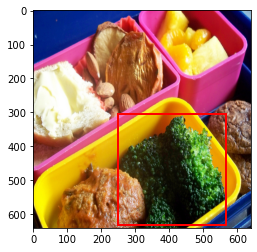

In [172]:
im_show(image, label)

In [12]:
image.size()

torch.Size([3, 480, 640])

In [13]:
# 注意，缩放图片并不需要对Label进行处理，因为label里面存的都是相对坐标。
transform = transforms.Resize((640, 640), )

In [14]:
image = transform(image)

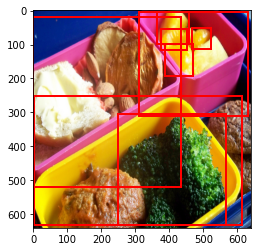

In [15]:
im_show(image, label)

In [16]:
# 对图片进行正则化
image = image / 255.

# 模型搭建

In [88]:
anchors_list = [
    [10,13, 33,23, 62,45],
    [59,119, 156,198, 373,326]
]

stride = [16, 32]

In [17]:
import pkg_resources as pkg


def check_version(current='0.0.0', minimum='0.0.0', name='version ', pinned=False, hard=False):
    # Check version vs. required version
    current, minimum = (pkg.parse_version(x) for x in (current, minimum))
    result = (current == minimum) if pinned else (current >= minimum)  # bool
    if hard:  # assert min requirements met
        assert result, f'{name}{minimum} required by YOLOv3, but {name}{current} is currently installed'
    else:
        return result

In [18]:
def autopad(k, p=None):  # kernel, padding
    # Pad to 'same'
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p

In [19]:
class Conv(nn.Module):
    # Standard convolution
    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, act=True):  # ch_in, ch_out, kernel, stride, padding, groups
        super().__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, autopad(k, p), groups=g, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = nn.SiLU() if act is True else (act if isinstance(act, nn.Module) else nn.Identity())

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

    def forward_fuse(self, x):
        return self.act(self.conv(x))

In [20]:
class Concat(nn.Module):
    # Concatenate a list of tensors along dimension
    def __init__(self, dimension=1):
        super().__init__()
        self.d = dimension

    def forward(self, x):
        return torch.cat(x, self.d)

In [21]:
class Detect(nn.Module):

    def __init__(self):
        super().__init__()
        self.n_anchors = 3
        self.n_outputs = 80 + 5  # 每个anchor输出的数量，80个类别+4个坐标+1个置信度

        self.m = nn.ModuleList(
            [
                nn.Conv2d(256, 255, 1, 1),
                nn.Conv2d(512, 255, 1, 1)
            ],
        )

    def forward(self, x):
        outputs = []
        for i in range(len(self.m)):
            # 最后输出两个不同尺度的TODO
            output = self.m[i](x[i])
            # 由于有3个anchor，所以需要将output的Shape从(batch_size, 255, 20, 20)转换为(batch_size, 3, 20 ,20, 85)
            bs, _, ny, nx = output.shape
            output = output.view(bs, self.n_anchors, self.n_outputs, ny, nx).permute(0, 1, 3, 4, 2).contiguous()

            outputs.append(output)
        return outputs

In [22]:
class YoloV3Tiny(nn.Module):

    def __init__(self):
        super(YoloV3Tiny, self).__init__()
        self.backbone_0 = Conv(3, 16, 3, 1)  # 0
        self.backbone_1 = nn.MaxPool2d(2, 2, 0)  # 1
        self.backbone_2 = Conv(16, 32, 3, 1)
        self.backbone_3 = nn.MaxPool2d(2, 2, 0)  # 3
        self.backbone_4 = Conv(32, 64, 3, 1)
        self.backbone_5 = nn.MaxPool2d(2, 2, 0)  # 5
        self.backbone_6 = Conv(64, 128, 3, 1)
        self.backbone_7 = nn.MaxPool2d(2, 2, 0)  # 7
        self.backbone_8 = Conv(128, 256, 3, 1)
        self.backbone_9 = nn.MaxPool2d(2, 2, 0)  # 9
        self.backbone_10 = Conv(256, 512, 3, 1)
        self.backbone_11 = nn.ZeroPad2d([0, 1, 0, 1])  # 11
        self.backbone_12 = nn.MaxPool2d(2, 1, 0)  # 12

        self.head_13 = Conv(512, 1024, 3, 1)
        self.head_14 = Conv(1024, 256, 1, 1)
        self.head_15 = Conv(256, 512, 3, 1)
        self.head_16 = Conv(256, 128, 1, 1)
        self.head_17 = nn.Upsample(None, 2, 'nearest')
        self.head_18 = Concat(1)
        self.head_19 = Conv(384, 256, 3, 1)
        self.head_20 = Detect()

    def forward(self, images):
        outputs = self.backbone_0(images)
        outputs = self.backbone_1(outputs)
        outputs = self.backbone_2(outputs)
        outputs = self.backbone_3(outputs)
        outputs = self.backbone_4(outputs)
        outputs = self.backbone_5(outputs)
        outputs = self.backbone_6(outputs)
        outputs = self.backbone_7(outputs)
        outputs_8 = self.backbone_8(outputs)
        outputs = self.backbone_9(outputs_8)
        outputs = self.backbone_10(outputs)
        outputs = self.backbone_11(outputs)
        outputs = self.backbone_12(outputs)

        outputs = self.head_13(outputs)
        outputs_14 = self.head_14(outputs)
        outputs_15 = self.head_15(outputs_14)
        outputs = self.head_16(outputs_14)
        outputs = self.head_17(outputs)
        outputs = self.head_18([outputs, outputs_8])
        outputs_19 = self.head_19(outputs)
        outputs = self.head_20([outputs_19, outputs_15])
        return outputs

In [23]:
model = YoloV3Tiny()

In [24]:
pred = model(image.unsqueeze(0))

In [25]:
pred[0].size()

torch.Size([1, 3, 40, 40, 85])

In [26]:
pred[1].size()

torch.Size([1, 3, 20, 20, 85])

# 模型训练

In [27]:
def wh_iou(wh1, wh2):
    # Returns the nxm IoU matrix. wh1 is nx2, wh2 is mx2
    wh1 = wh1[:, None]  # [N,1,2]
    wh2 = wh2[None]  # [1,M,2]
    inter = torch.min(wh1, wh2).prod(2)  # [N,M]
    return inter / (wh1.prod(2) + wh2.prod(2) - inter)  # iou = inter / (area1 + area2 - inter)

In [28]:
def bbox_iou(box1, box2, x1y1x2y2=True, GIoU=False, DIoU=False, CIoU=False):
    # Returns the IoU of box1 to box2. box1 is 4, box2 is nx4
    box2 = box2.t()

    # Get the coordinates of bounding boxes
    if x1y1x2y2:  # x1, y1, x2, y2 = box1
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[0], box1[1], box1[2], box1[3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[0], box2[1], box2[2], box2[3]
    else:  # transform from xywh to xyxy
        b1_x1, b1_x2 = box1[0] - box1[2] / 2, box1[0] + box1[2] / 2
        b1_y1, b1_y2 = box1[1] - box1[3] / 2, box1[1] + box1[3] / 2
        b2_x1, b2_x2 = box2[0] - box2[2] / 2, box2[0] + box2[2] / 2
        b2_y1, b2_y2 = box2[1] - box2[3] / 2, box2[1] + box2[3] / 2

    # Intersection area
    inter = (torch.min(b1_x2, b2_x2) - torch.max(b1_x1, b2_x1)).clamp(0) * \
            (torch.min(b1_y2, b2_y2) - torch.max(b1_y1, b2_y1)).clamp(0)

    # Union Area
    w1, h1 = b1_x2 - b1_x1, b1_y2 - b1_y1
    w2, h2 = b2_x2 - b2_x1, b2_y2 - b2_y1
    union = (w1 * h1 + 1e-16) + w2 * h2 - inter

    iou = inter / union  # iou
    if GIoU or DIoU or CIoU:
        cw = torch.max(b1_x2, b2_x2) - torch.min(b1_x1, b2_x1)  # convex (smallest enclosing box) width
        ch = torch.max(b1_y2, b2_y2) - torch.min(b1_y1, b2_y1)  # convex height
        if GIoU:  # Generalized IoU https://arxiv.org/pdf/1902.09630.pdf
            c_area = cw * ch + 1e-16  # convex area
            return iou - (c_area - union) / c_area  # GIoU
        if DIoU or CIoU:  # Distance or Complete IoU https://arxiv.org/abs/1911.08287v1
            # convex diagonal squared
            c2 = cw ** 2 + ch ** 2 + 1e-16
            # centerpoint distance squared
            rho2 = ((b2_x1 + b2_x2) - (b1_x1 + b1_x2)) ** 2 / 4 + ((b2_y1 + b2_y2) - (b1_y1 + b1_y2)) ** 2 / 4
            if DIoU:
                return iou - rho2 / c2  # DIoU
            elif CIoU:  # https://github.com/Zzh-tju/DIoU-SSD-pytorch/blob/master/utils/box/box_utils.py#L47
                v = (4 / math.pi ** 2) * torch.pow(torch.atan(w2 / h2) - torch.atan(w1 / h1), 2)
                with torch.no_grad():
                    alpha = v / (1 - iou + v)
                return iou - (rho2 / c2 + v * alpha)  # CIoU

    return iou

In [29]:
def build_targets(p, targets):
    # Build targets for compute_loss(), input targets(image_idx,class,x,y,w,h)
    nt = targets.shape[0]
    tcls, tbox, indices, anch = [], [], [], []
    gain = torch.ones(6, device=targets.device)  # normalized to gridspace gain

    for i, anchors in enumerate(anchors_list):  # j: [89, 101, 113]
        # 获取该yolo predictor对应的anchors
        # 注意anchor_vec是anchors缩放到对应特征层上的尺度
        anchors = torch.tensor(anchors).float() / stride[i]
        anchors = anchors.view(3, 2)
        # p[i].shape: [batch_size, 3, grid_h, grid_w, num_params]
        gain[2:] = torch.tensor(p[i].shape)[[3, 2, 3, 2]]  # xyxy gain
        na = anchors.shape[0]  # number of anchors
        # [3] -> [3, 1] -> [3, nt]
        at = torch.arange(na).view(na, 1).repeat(1, nt)  # anchor tensor, same as .repeat_interleave(nt)

        # Match targets to anchors
        a, t, offsets = [], targets * gain, 0
        if nt:  # 如果存在target的话
            # 通过计算anchor模板与所有target的wh_iou来匹配正样本
            # j: [3, nt] , iou_t = 0.20
            j = wh_iou(anchors, t[:, 4:6]) > 0.2
            # t.repeat(na, 1, 1): [nt, 6] -> [3, nt, 6]
            # 获取正样本对应的anchor模板与target信息
            a, t = at[j], t.repeat(na, 1, 1)[j]  # filter

        # Define
        # long等于to(torch.int64), 数值向下取整
        b, c = t[:, :2].long().T  # image_idx, class
        gxy = t[:, 2:4]  # grid xy
        gwh = t[:, 4:6]  # grid wh
        gij = (gxy - offsets).long()  # 匹配targets所在的grid cell左上角坐标
        gi, gj = gij.T  # grid xy indices

        # Append
        # gain[3]: grid_h, gain[2]: grid_w
        # image_idx, anchor_idx, grid indices(y, x)
        indices.append((b, a, gj.clamp_(0, gain[3].long()-1), gi.clamp_(0, gain[2].long()-1)))
        tbox.append(torch.cat((gxy - gij, gwh), 1))  # gt box相对anchor的x,y偏移量以及w,h
        anch.append(anchors[a])  # anchors
        tcls.append(c)  # class

    return tcls, tbox, indices, anch

In [30]:
targets = torch.tensor(label)

In [31]:
build_targets(pred, targets)

([tensor([49, 49, 49, 49, 49]),
  tensor([49, 49, 49, 49, 45, 50, 49, 49, 45, 45, 50, 45])],
 [tensor([[0.9259, 0.1921, 3.6294, 3.8892],
          [0.8734, 0.3021, 4.7219, 3.8775],
          [0.9259, 0.1921, 3.6294, 3.8892],
          [0.7319, 0.0762, 5.2512, 5.8758],
          [0.7144, 0.1688, 5.9225, 5.9225]]),
  tensor([[ 0.9367,  0.6510,  2.3609,  1.9387],
          [ 0.4630,  0.5960,  1.8147,  1.9446],
          [ 0.3659,  0.5381,  2.6256,  2.9379],
          [ 0.8572,  0.5844,  2.9613,  2.9612],
          [ 0.7303,  0.9438,  9.9775,  9.5283],
          [ 0.7413,  0.6588,  9.8825, 10.2117],
          [ 0.3659,  0.5381,  2.6256,  2.9379],
          [ 0.8572,  0.5844,  2.9613,  2.9612],
          [ 0.5898,  0.7754, 19.1122, 11.9100],
          [ 0.7303,  0.9438,  9.9775,  9.5283],
          [ 0.7413,  0.6588,  9.8825, 10.2117],
          [ 0.7888,  0.3779, 13.5775, 15.6300]])],
 [(tensor([0, 0, 0, 0, 0]),
   tensor([1, 2, 2, 2, 2]),
   tensor([5, 5, 5, 9, 3]),
   tensor([30, 25, 30,

In [59]:
def compute_loss(p, targets):  # predictions, targets, model
    device = p[0].device
    lcls = torch.zeros(1, device=device)  # Tensor(0)
    lbox = torch.zeros(1, device=device)  # Tensor(0)
    lobj = torch.zeros(1, device=device)  # Tensor(0)
    tcls, tbox, indices, anchors = build_targets(p, targets)  # targets

    # Define criteria
    BCEcls = nn.BCEWithLogitsLoss()
    BCEobj = nn.BCEWithLogitsLoss()

    # per output
    for i, pi in enumerate(p):  # layer index, layer predictions
        b, a, gj, gi = indices[i]  # image_idx, anchor_idx, grid_y, grid_x
        tobj = torch.zeros_like(pi[..., 0], device=device)  # target obj

        nb = b.shape[0]  # number of positive samples
        if nb:
            # 对应匹配到正样本的预测信息
            ps = pi[b, a, gj, gi]  # prediction subset corresponding to targets

            # GIoU
            pxy = ps[:, :2].sigmoid()
            pwh = ps[:, 2:4].exp().clamp(max=1E3) * anchors[i]
            pbox = torch.cat((pxy, pwh), 1)  # predicted box
            giou = bbox_iou(pbox.t(), tbox[i], x1y1x2y2=False, GIoU=True)  # giou(prediction, target)
            lbox += (1.0 - giou).mean()  # giou loss

            # Obj
            tobj[b, a, gj, gi] = giou.detach().clamp(0).type(tobj.dtype)  # giou ratio

            # Class
            t = torch.full_like(ps[:, 5:], 0, device=device)  # targets
            t[range(nb), tcls[i]] = 1
            lcls += BCEcls(ps[:, 5:], t)  # BCE

            # Append targets to text file
            # with open('targets.txt', 'a') as file:
            #     [file.write('%11.5g ' * 4 % tuple(x) + '\n') for x in torch.cat((txy[i], twh[i]), 1)]

        lobj += BCEobj(pi[..., 4], tobj)  # obj loss

    # 乘上每种损失的对应权重
    lbox *= 3.54
    lobj *= 64.3
    lcls *= 37.4

    # loss = lbox + lobj + lcls
    return {"box_loss": lbox,
            "obj_loss": lobj,
            "class_loss": lcls}

开始训练模型：

In [60]:
model = YoloV3Tiny()
model = model.train()

In [61]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [62]:
for epoch in range(10000):
    pred = model(image.unsqueeze(0))
    loss_dict = compute_loss(pred, targets)
    losses = sum(loss for loss in loss_dict.values())
    losses.backward()
    optimizer.step()
    optimizer.zero_grad()

    if epoch % 20 == 0:
        print(f"epoch {epoch}, box_loss: {loss_dict['box_loss'].item()}, obj_loss: {loss_dict['obj_loss'].item()}, class_loss: {loss_dict['class_loss'].item()}, losses: {losses.item()}")
    # break

epoch 0, box_loss: 4.4746785163879395, obj_loss: 86.29159545898438, class_loss: 52.96608352661133, losses: 143.73236083984375
epoch 20, box_loss: 4.80690336227417, obj_loss: 53.707374572753906, class_loss: 0.9452560544013977, losses: 59.45953369140625
epoch 40, box_loss: 4.231696128845215, obj_loss: 37.88326644897461, class_loss: 0.4703485369682312, losses: 42.58531188964844
epoch 60, box_loss: 4.019769191741943, obj_loss: 28.03516387939453, class_loss: 0.40064460039138794, losses: 32.4555778503418
epoch 80, box_loss: 2.7162957191467285, obj_loss: 21.398984909057617, class_loss: 0.3619728982448578, losses: 24.477252960205078
epoch 100, box_loss: 1.8556491136550903, obj_loss: 16.686992645263672, class_loss: 0.3138718008995056, losses: 18.85651397705078
epoch 120, box_loss: 2.207688570022583, obj_loss: 13.14861011505127, class_loss: 0.2641466557979584, losses: 15.620445251464844
epoch 140, box_loss: 1.390012502670288, obj_loss: 10.641953468322754, class_loss: 0.23435357213020325, losses:

KeyboardInterrupt: 

In [63]:
torch.save(model, 'my-yolo-tiny3.pt')

# 模型推理

In [114]:
def make_grid(nx, ny):
    n_anchors = 3
    yv, xv = torch.meshgrid([torch.arange(nx), torch.arange(ny)], indexing='ij')
    grid = torch.stack((xv, yv), 2).expand((1, n_anchors, nx, ny, 2)).float()
    return grid

In [115]:
def make_anchor_grid(nx, ny, i):
    anchors = torch.tensor(anchors_list[i]).view(-1, 2)
    n_anchors = 3

    yv, xv = torch.meshgrid([torch.arange(ny), torch.arange(nx)], indexing='ij')
    anchor_grid = anchors.view((1, n_anchors, 1, 1, 2)).expand((1, n_anchors, ny, nx, 2)).float()
    return anchor_grid

In [127]:
def detect_resolve(pred):
    inference_output = []
    for i in range(len(pred)):
        batch_size, _, ny, nx, _ = pred[i].shape

        y =  pred[i].sigmoid()
        y[..., 0:2] = (y[..., 0:2] * 2 - 0.5 + make_grid(nx, ny)) * stride[i]  # xy
        y[..., 2:4] = (y[..., 2:4] * 2) ** 2 * make_anchor_grid(nx, ny, i)  # wh

        inference_output.append(y.view(batch_size, -1, n_output))

    return (torch.cat(inference_output, 1), pred)

In [147]:
def non_max_suppression(prediction, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False, multi_label=False,
                        labels=(), max_det=300):
    """Runs Non-Maximum Suppression (NMS) on inference results
    prediction: 预测结果，即模型的输出。shape为(batch_size, 7938(TODO), 85)
    conf_thres: confident threshold，置信度阈值。当置信度低于该值时，舍弃该边框。“是否检测出物体”和“物体类别”的置信度阈值都用这个
    iou_thres: iou threshold。 TODO
    classes: 指定要预测的类别，比如模型可以支持0-79的类别，但你执行detect类别3，那classes就可以指定3
    agnostic: TODO
    multi_label: 是否为多类别，一个候选框内是否可能会有多种物体。
    labels: TODO
    max_det: max detection， 最大检测数量。即最后的输出最多几个框。

    Returns:
         list of detections, on (n,6) tensor per image [xyxy, conf, cls]
         返回的是一个list，即每张图片的结果。每个元素的shape为(n, 6), 即n个物体，每个物体的xyxy, 置信度和类别。
                          注：这里的xy,xy分别为左上角坐标和右下角坐标，且是针对resize后的图片，而非原图。
    """

    nc = prediction.shape[2] - 5  # number of classes
    # 找出置信度小于conf_thres的候选框
    xc = prediction[..., 4] > conf_thres  # candidates

    # Checks
    assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0'
    assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0'

    # Settings
    # TODO
    min_wh, max_wh = 2, 4096  # (pixels) minimum and maximum box width and height
    # TODO
    max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
    # TODO
    time_limit = 10.0  # seconds to quit after
    # TODO
    redundant = True  # require redundant detections
    # TODO
    multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
    # 是否合并重叠的框
    merge = False  # use merge-NMS

    t = time.time()
    # 初始化输出
    output = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
    for xi, x in enumerate(prediction):  # image index, image inference
        # Apply constraints
        # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
        # 过滤掉当前（第xi个）图片中，置信度较低的候选框。例如，过滤前x.shape=(7983, 85), 过滤后为(980, 85)
        x = x[xc[xi]]  # confidence

        # Cat apriori labels if autolabelling
        # TODO
        if labels and len(labels[xi]):
            l = labels[xi]
            v = torch.zeros((len(l), nc + 5), device=x.device)
            v[:, :4] = l[:, 1:5]  # box
            v[:, 4] = 1.0  # conf
            v[range(len(l)), l[:, 0].long() + 5] = 1.0  # cls
            x = torch.cat((x, v), 0)

        # If none remain process next image
        # 如果过滤完后，一个候选框都没了，则处理下一张图片
        if not x.shape[0]:
            continue

        # Compute conf
        # x[:, 4:5] 是obj_conf(物体置信度，即有多大概率这里有物体)
        # x[:, 5:] 是cls_conf（类别置信度，即每个类别的概率）
        x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

        # Box (center x, center y, width, height) to (x1, y1, x2, y2)
        # 将 x,y,w,h （中心点坐标+宽高）转化为 xyxy（左上角坐标+右下角坐标）
        # box的shape为(n, 4), 其中4为(x1, y1, x2, y2), 其中(x1, y1)为左上角的坐标，(x2, y2)为右下角的坐标
        box = xywh2xyxy(x[:, :4])

        # Detections matrix nx6 (xyxy, conf, cls)
        if multi_label:
            """
            x[:, 5:] > conf_thres: 找出类别中置信度比较高的。
            non_zero: 找出非0元素的位置。这里的作用是找出那些置信度大于阈值的类别。
                      如果阈值设的比较小，那么一个框可能会有多个类别都大于阈值，最后的结果会比原来多。
            最终的结果为（举例）：
            i = [  0,   1,   2,  ..., 446, 447, 448];  这里i是有重复元素的
            j = [22,   22,  22,  ..., 22,  22,  22]
            其中，i中元素代表第i个候选框，j中元素代表第i个候选框的类别。因为i是有重复的，所以len(i)会大于候选框数量。
            """
            i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
            """
            box[i]：找出所有的候选框。box[i].shape = (1169, 4)
            x[i, j+5, None]: 找出所有候选框对应类别的置信度。j+5是因为上面x是从5开始的，这里是从0开始的。None目的是再后面加一维。
                             x[i, j+5, None].shape = (1169, 1)
            j[:, None]: 找出所有候选框对应的类别。
            最终， x.shape = (1169, 6)
            """
            x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
        else:  # best class only
            # 参考上，如果一个候选框内默认只有一种物体的话，就不需要用置信度了，直接选最大的那个就好了。
            conf, j = x[:, 5:].max(1, keepdim=True)
            x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]

        # Filter by class
        # 只要指定的类别，其他都不要
        if classes is not None:
            x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

        # Apply finite constraint
        # if not torch.isfinite(x).all():
        #     x = x[torch.isfinite(x).all(1)]

        # Check shape
        n = x.shape[0]  # number of boxes
        # 如果过滤之后没有检测到任何物体，则continue
        if not n:  # no boxes
            continue
        # 若过滤后剩下的框比max_nms还多，则按置信度排序，选取前max_nms个。
        elif n > max_nms:  # excess boxes
            x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence

        # Batched NMS
        # TODO
        c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
        # TODO
        boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
        # 通过pytorch提供的nms算法进行筛选。最终的返回为indexes，按照分数从高到低排。
        # 例如：i = [1025, 1046,  820,  814,  305,  850, ...]
        i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
        # 按照max_det再减少些框。最终框的数量不能超过max_det
        if i.shape[0] > max_det:  # limit detections
            i = i[:max_det]
        # 将框进行合并
        if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
            # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
            iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
            weights = iou * scores[None]  # box weights
            x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
            if redundant:
                i = i[iou.sum(1) > 1]  # require redundancy
        # 第xi个图片预测完毕，将结果保存到output[xi]中
        output[xi] = x[i]
        if (time.time() - t) > time_limit:
            print(f'WARNING: NMS time limit {time_limit}s exceeded')
            break  # time limit exceeded

    return output

In [167]:
pred = model(image.unsqueeze(0))

In [168]:
pred = detect_resolve(pred)[0]

In [169]:
pred = non_max_suppression(pred)

In [163]:
pred[0][:, 0:4] = pred[0][:, 0:4] / 640

In [170]:
pred[0]

tensor([[376.6594,   4.3018, 469.0378, 102.5669,   0.9615,  49.0000],
        [383.1043,  97.8911, 465.0195, 195.4624,   0.9442,  49.0000],
        [474.9877,  47.1664, 528.6430, 108.1861,   0.9423,  49.0000],
        [390.1638,  60.6070, 465.3389, 119.6013,   0.9403,  49.0000],
        [ 11.1234,  16.4447, 439.1885, 513.0598,   0.9370,  45.0000],
        [252.3577, 313.5687, 574.4720, 636.3322,   0.9368,  50.0000],
        [324.3874,  20.2393, 629.5262, 322.7171,   0.9334,  45.0000],
        [ 27.2083, 256.6775, 592.2460, 642.1270,   0.9286,  45.0000]],
       grad_fn=<IndexBackward0>)